# Cifar10 Image Classification with MLP
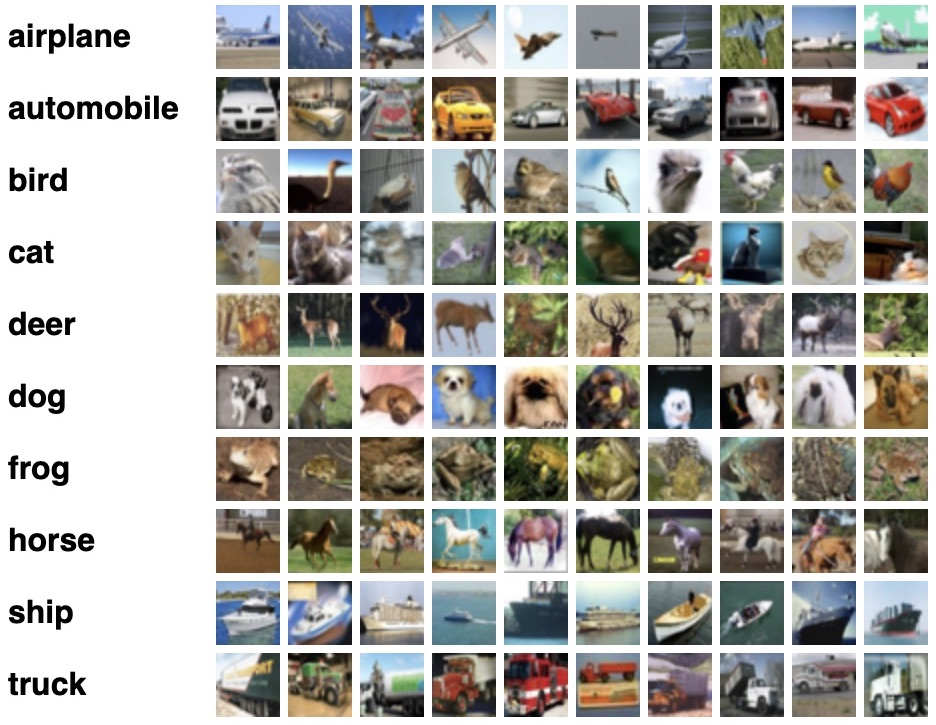
#### 60.000 32x32 pixel RGB color images divided among 10 classes
There are 5000 of each class in the training sets and 1000 of each class in the test sets.
Cifar10 Dataset: https://keras.io/api/datasets/cifar10/
This is a multi-label classification - supervised learning  problem.
#### Introduction
For this solution, I will work with Deep Learning and create an MLP model to perform the classification. DL models have more than one hidden layer. A neural network have at least an input, hidden layer and an output layer. To perform the classification, I want to create multiple layers to distingiush patterns in the data. The input layers is where the training parameters are passed and the features are then evaluated in the hidden layers. The hidden layers have nodes / neurons which are activated and each output is passed through the network, until reaching a collected output through the output layer. The output layer should be the number of classes in the dataset; in this case 10 outputs. This is forward propagation. The weights and biases are unique for each node, which results in unique activations. Each node output is compared by cost. The cost is calculated by generated output - actual output. The cost is reduced by adjusting weight and biases to fit the output.

## Imports

In [1]:
# Common imports
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from __future__ import print_function
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 1. Gather Data
#### Load the Kears Cifar10 Dataset
The Keras API lets us import the dataset simply by calling .load_data() on their datasets. Thare are 10 labels consisting of 32x32 pixels and colors. This means, that the image labels are the class names and features are the pixels. 

In [2]:
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

In [3]:
print(X_train_full.shape)
print(y_train_full.shape)

(50000, 32, 32, 3)
(50000, 1)


In [4]:
print(X_test.shape)
print(y_test.shape)

(10000, 32, 32, 3)
(10000, 1)


## 2. Data Preperation
#### Check for missing values
NaN is the absense of values. To remove missing values use .dropna(). There are no missing values in this dataset and the data is evenly distributed among the classes. 

In [5]:
np.isnan(X_train_full).any()

False

In [6]:
np.isnan(X_test).any()

False

#### Data Normalization
Because the images are color pixel images, some normalization is required in order to proceed with the dataset. First; convert the datatype of x values from uint8 (values 0-255) to float32 (values -1-0 or 0-1). This normalizes the input data to a range from 0 to 1. Cross-validation: Split the full training set into a validation set and a (smaller). It is common practice to split the training set into a smaller validation set used for cross-validation. This can help to identify and prevent the model from overfitting (over adapting the known data-patterns). The test datasets will remain hidden for the model and then presented as new data for a more accurate model evaluation. 

In [7]:
X_train_full.dtype

dtype('uint8')

In [8]:
X_train_full = X_train_full.astype('float32')
X_test = X_test.astype('float32')

# Split the full training set into a validation set and a (smaller) training set.
# Normalize the input data to a range from 0 to 1.
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [9]:
print("X_train dtype: {} and shape: {}".format(X_train.dtype, X_train.shape))

X_train dtype: float32 and shape: (45000, 32, 32, 3)


In [10]:
print("X_test dtype: {} and shape: {}".format(X_test.dtype, X_test.shape))

X_test dtype: float32 and shape: (10000, 32, 32, 3)


In [11]:
print("X_valid dtype: {} and shape: {}".format(X_valid.dtype, X_valid.shape))

X_valid dtype: float32 and shape: (5000, 32, 32, 3)


#### One Hot Label-encoding
The labels are categorical values and needs to be converted to binary / continious data. This can be achived with the keras.utils.to_categorical callback.  
The imshow and y_valid labels confirms, that the labels have been properly encoded. 

In [12]:
num_classes = 10

# Convert class vectors to binary class matrices with one hot encoding.
# num_classes is 10.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


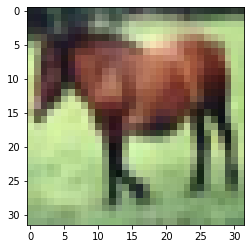

In [13]:
# Shows of the encoding from categorical to continious. 
# Ex. Horse. 
plt.imshow(X_valid[7])
print(y_valid[7])

## 3. Choosing a Model
#### Create Sequential MLP Model
An MLP (Multi-layered Perceptron) is used in Deep Learning. It is based upon the regular percetron - but suitable for neural networks with more than one hidden layer. I will build this model with 10 hidden layers of each 100 neurons. These neurons will be activated with ReLU. The dropout rate is 0.2 which is very standard. The dropout rate determines; how many neurons with 0 / False as output should be dropped from each hidden layer. This fits under the category of regularization. The output layers are not tampered with or regulated. The output layers must allways be identical to the number of classification labels. In this case; 10 or num_classes. The outputs are activated with softmax - this activation function is commonly used for multi-classification. When setting up the layers and density - it is important to remember, that each layer gets more and more abstract, which is why more layers can often be better than adding neurons to the layers. When using ReLU as weight activation function; 512 is the max amount of available neurons in each layer. Regularization like dropout rate contributes to prevent an overfitted model. But if the model is underfitted some of the applied regularization techniques can be minimized.  

In [14]:
# MLP - Multi-layered Perceptron. 
model = keras.models.Sequential()
# Input layer:
# A "Flatten" layer converts each input image into a 1-dimensional array.
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
# An MLP have more than one hidden layer.
# Each layer can add more and more detail and is why it is a must for more complex classification. 
# Hidden layers:
for layer in range(10):
    # Each layer have 100 nodes in each layer and they are activated with ReLU - Recktified Liniar Unit. 
    model.add(keras.layers.Dense(100, activation="relu"))

# Use alpha dropout in the last hidden layer.
# Drops nodes with 0 as output in each layer. 
model.add(keras.layers.AlphaDropout(rate=0.2))
# Output layer.
# Since it is multiclass classification, we should use the softmax activation function.
# The dense is equeal to the number of classes in the dataset. 
model.add(keras.layers.Dense(num_classes, activation="softmax"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               1

#### Compile Model
For compiling the model, the loss is measured in categorical_crossentropy because this is a classification issue. As optimizer the model compiles with SGD (Stohastic Gradient Descent), which helps backpropagation. In supervised learning, we allready know what the true labels should be. The learning is then based on the model adjusting its algorithm to fit the true labels. Backpropagation helps the algorithm the improve based on previous output throughout a training iteration. 

In [16]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(momentum=0.9),
              metrics=["accuracy"])

## 4. Training
The history of the model is fitted and trained to measure accuracy and loss. It is often suggested to use preproccesing for more complex images like color images in this section. I tried to implement it - but the training time and gain did not make it a great fit for this solution. To prevent the model from future overfitting; early stopping is implemented along with a learning rate scheduler. The validation data is the valid sets, which means there is still data "hidden" from the model, which can help to idenfity if the model is overly adapted to the dataset.  

In [17]:
epochs = 100  # Number of training iterations
batch_size = 32  # Standard - Keras Default size. Batch size works like somewhat like internal epochs.  

# EarlyStopping (with rollback to the best model).
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Performance scheduling
# (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

# Train the model with early stopping or performance scheduling or both. Training is much faster when
# early stopping is used, but a slightly better accuracy is achieved with performance scheduling alone.
history = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_valid, y_valid),
                    batch_size=batch_size, shuffle=True, 
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
1407/1407 [==============================] - 5s 3ms/step - loss: 2.1815 - accuracy: 0.1699 - val_loss: 2.0380 - val_accuracy: 0.2396 - lr: 0.0100
Epoch 2/100
1407/1407 [==============================] - 4s 3ms/step - loss: 2.0073 - accuracy: 0.2359 - val_loss: 2.0113 - val_accuracy: 0.2884 - lr: 0.0100
Epoch 3/100
1407/1407 [==============================] - 4s 3ms/step - loss: 1.9333 - accuracy: 0.2787 - val_loss: 1.9187 - val_accuracy: 0.3164 - lr: 0.0100
Epoch 4/100
1407/1407 [==============================] - 4s 3ms/step - loss: 1.8970 - accuracy: 0.2930 - val_loss: 1.9545 - val_accuracy: 0.2980 - lr: 0.0100
Epoch 5/100
1407/1407 [==============================] - 4s 3ms/step - loss: 1.8423 - accuracy: 0.3196 - val_loss: 1.9300 - val_accuracy: 0.3474 - lr: 0.0100
Epoch 6/100
1407/1407 [==============================] - 4s 3ms/step - loss: 1.8031 - accuracy: 0.3444 - val_loss: 1.7958 - val_accuracy: 0.3712 - lr: 0.0100
Epoch 7/100
1407/1407 [=============================

## 5. Evaluation
Now the model can be evaluated. The plot shows the measured training-results. 

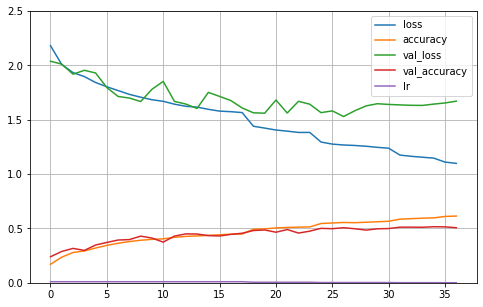

In [18]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2.5)
plt.show()

#### Goodness of Fit
To score / evaluate the model; the "hidden" test set is used. This will measure the models ability to reckonize new data based on adapted patterns from previous training. The result suggest, that this model could have a tendency to overfit (which can be expected in classification). The model scores an overall training accuracy just above 61% - but when presented to unknown data the accuracy score is just above 50%. Overall conclusion is, that to improve this model further - measurements for preventing overfitted should be considered - but the model actually performs rather poorley on known data aswell. This could indicate, that the model is currenly also underfitted and have a difficult time reckonizing patterns in general. The models lack of needed complexity cannot process the needed parameters to make reliable predictions.  

In [19]:
# Verbose is the log-level - like ls. 
scores = model.evaluate(X_test, y_test, verbose=1)
print('Measured test loss:', scores[0])
print('Measured test accuracy:', scores[1])

# make prediction.
pred = model.predict(X_test)

313/313 [==============================] - 0s 1ms/step - loss: 1.5171 - accuracy: 0.5058
Measured test loss: 1.5171164274215698
Measured test accuracy: 0.5058000087738037


In [20]:
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = X_test[errors]

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.56      0.61      0.59      1000
           1       0.64      0.63      0.63      1000
           2       0.39      0.35      0.37      1000
           3       0.31      0.36      0.34      1000
           4       0.44      0.37      0.40      1000
           5       0.41      0.31      0.35      1000
           6       0.48      0.63      0.54      1000
           7       0.60      0.58      0.59      1000
           8       0.68      0.61      0.65      1000
           9       0.55      0.59      0.57      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.50     10000
weighted avg       0.51      0.51      0.50     10000



[[Text(0.5, 0, 'Airplane'),
  Text(1.5, 0, 'Automobile'),
  Text(2.5, 0, 'Bird'),
  Text(3.5, 0, 'Cat'),
  Text(4.5, 0, 'Deer'),
  Text(5.5, 0, 'Dog'),
  Text(6.5, 0, 'Frog'),
  Text(7.5, 0, 'Horse'),
  Text(8.5, 0, 'Ship'),
  Text(9.5, 0, 'Truck')],
 [Text(0, 0.5, 'Airplane'),
  Text(0, 1.5, 'Automobile'),
  Text(0, 2.5, 'Bird'),
  Text(0, 3.5, 'Cat'),
  Text(0, 4.5, 'Deer'),
  Text(0, 5.5, 'Dog'),
  Text(0, 6.5, 'Frog'),
  Text(0, 7.5, 'Horse'),
  Text(0, 8.5, 'Ship'),
  Text(0, 9.5, 'Truck')]]

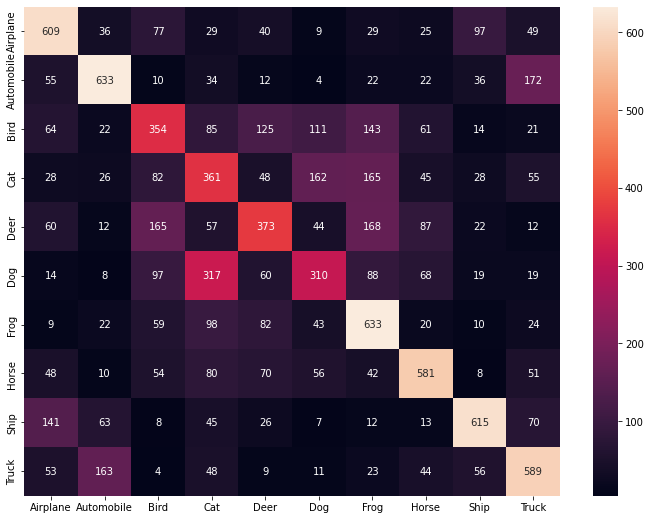

In [22]:
import seaborn as sns
# Heatmap of classes and predictions. 
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(confusion_mtx, annot=True, fmt='g')
heatmap.set(xticklabels=class_labels, yticklabels=class_labels)

#### Conclusion 
The model does not classify images of: cats, birds, deers or dogs very well. And particular the cat accuracy does not improve more than a few percentage points. The model is not complex enough to reckonize patterns for expecially these four labels. This result could suggest, that preproccesing these images could help with this issue - and a generally more complex model architecture to process all the features that each input contains. For this case, I did experiment with adding data augmentated training and more layers to the model. The accuracy did not improve over epochs and it was a very slow process. So I decided to proceed without. To get a high accuracy, I do not believe it would be worth trying to improve this solution. Instead if high accuracy is the goal; then go for a more complex classification model architecture - like a CNN (Convolutional Neural Network). I will not be covering this for now, as my topic of exploration was concered MLP architecture. But the model is definetly not complex enough to train with all the optimal parameters for the desired result.   

## 6. Hyperparameter Tuning

#### Keras Tuner
Fist I added a Random GridSearchCV - but i did not gain any useful knowledge from what I tried and this process was expecially slow. Instead I went with the Keras Tuner approach instead which seems more fitting. 

In [63]:
import keras_tuner as kt

def build_model(hp):
    model.add(keras.layers.Flatten(input_shape=[32,32,3]))
    model = keras.Sequential()
    model.add(keras.layers.Dense(
        hp.Choice('units', [8, 16, 32]),
        activation='relu'))
    model.add(keras.layers.Dense(10, activation='relu'))
    model.compile(loss='categorical_crossentropy')
    return model

In [64]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='dir', # directory to save logs 
project_name='khyperband')

INFO:tensorflow:Reloading Oracle from existing project dir\khyperband\oracle.json
INFO:tensorflow:Reloading Tuner from dir\khyperband\tuner0.json


In [65]:
# hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [66]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[stop_early])

Trial 42 Complete [00h 00m 45s]
val_accuracy: 0.41200000047683716

Best val_accuracy So Far: 0.47040000557899475
Total elapsed time: 00h 06m 12s
INFO:tensorflow:Oracle triggered exit


In [77]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

In [83]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
h_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 448)               1376704   
                                                                 
 dropout_5 (Dropout)         (None, 448)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                4490      
                                                                 
Total params: 1,381,194
Trainable params: 1,381,194
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.9069 - accuracy: 0.3149 - val_loss: 1.7725 - val_accuracy: 0.3618
Epoch 2/10
1407/1407 [==========

## 7. Prediction

In [85]:
h_eval_dict = h_model.evaluate(X_test, y_test, return_dict=True)

313/313 [==============================] - 1s 2ms/step - loss: 1.5379 - accuracy: 0.4539
